In [44]:
import pandas as pd
import os
from plotnine import *  # type: ignore
dir = "data"
plots_dir = "plots"

# Setup 1
- tests the whole benchmark tool, with 1,3,5,10
- start_vector_mul.sh

In [ ]:
# plot for each function
filename = 'myexp-application_metrics.csv'
df = pd.read_csv(os.path.join(dir, filename))
df = df[df["entity"] == "f"]
df["name"] = df["name"].astype("category")
df["chain_length"] = df["chain_length"].astype("category")
print(df["name"].nunique())
plot = (
    ggplot(df, aes(x="timestamp", y="value", shape="chain_length", color="name"))
        + geom_point()
        + guides(color=False)
)
plot.show()

In [ ]:
filename = 'myexp-application_metrics.csv'
df = pd.read_csv(os.path.join(dir, filename))
# filter out function metrics
df = df[df["entity"] == "w"]
df['chain_length'] = df["chain_length"].astype("category")

# boxplot
plot = (
    ggplot(df, aes(x="chain_length", y="value"))
        + geom_boxplot()
)
plot.show()

# timeline
duration = df["timestamp"].max() - df["timestamp"].min()
print("the duration of the entire experiment was {:.2f} seconds".format(duration))

# how latency changes over time
plot = (
    ggplot(df, aes(x="timestamp", y="value", color="chain_length"))
    + geom_point()
    + labs(
        title="Latency of an entire workflow",
        x="timestamp",
        y="latency (ms)",
    )
)
plot.show()


# Setup 2
- one dda function (single), calls actions on an external actor, waits for a
  response and returns
- self triggered through delayed_casts

- plot the dataplane stat of dda sidecar on the same timeline graph

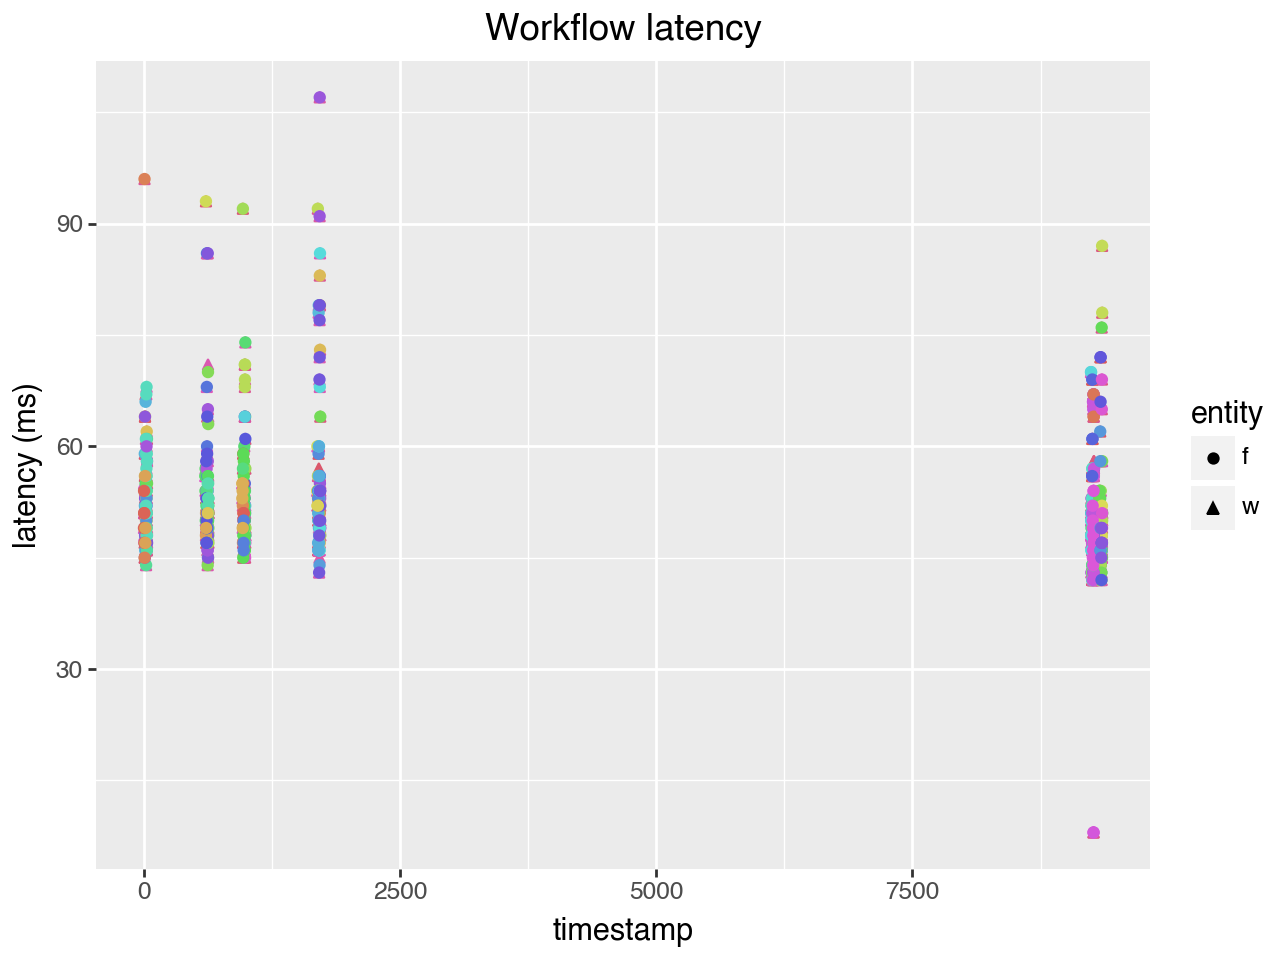

Mean ± SD: 52.19 ± 8.95


In [84]:
# show all workflows on the same plot, different colors
# add legend for workflow length
filename = 'dda-exp-application_metrics.csv'
df = pd.read_csv(os.path.join(dir, filename))
# timestamp is in seconds (unix epoch time)
df["timestamp"] = df["timestamp"] - df["timestamp"].min()

# how latency of a workflow changes over time
w_plot = (
    ggplot(df, aes(x="timestamp", y="value", color="name", shape="entity"))
        + geom_point()
        + labs(
            title="Workflow latency",
            x="timestamp",
            y="latency (ms)")
        + guides(color=False)
)
w_plot.show()
# w_plot.save(os.path.join(plots_dir, "plot_40ms_mocked"))

mean = df["value"].mean()
std = df["value"].std()
print(f"Mean ± SD: {mean:.2f} ± {std:.2f}")

# f_plot = (
#     ggplot(df[df["entity" == "f"]], aes(x="timestamp", y="value", color="name"))
#         + geom_point()
#         + labs(
#             title="Function latency",
#             x="timestamp",
#             y="latency (ms)")
#         + guides(color=False)
# )
# f_plot.show()
# plot_name = "plot_" + str(len(os.listdir(plots_dir)))
# plot.save(os.path.join(plots_dir, plot_name))

# Setup 3 - dda chained, demonstrates the blocking of the dataplane